<a href="https://colab.research.google.com/github/crash13205/P2P-RL/blob/main/MyProj.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install stable_baselines3

In [71]:
import gym
import numpy as np
import pandas as pd
from stable_baselines3 import TD3
from gym import spaces
from gym.utils import seeding

In [72]:
!git clone https://github.com/crash13205/P2P-RL.git

fatal: destination path 'P2P-RL' already exists and is not an empty directory.


In [73]:
df = pd.read_excel('/content/P2P-RL/ProsumersDB.xlsx',sheet_name="P1",usecols ='A:C')
print(df)

       Date                 Time  Electricity:Facility [kW](Hourly)
0      1.01             01:00:00                           0.432224
1      1.01             02:00:00                           0.384612
2      1.01             03:00:00                           0.373588
3      1.01             04:00:00                           0.372316
4      1.01             05:00:00                           0.361980
...     ...                  ...                                ...
8755  12.31             20:00:00                           0.854154
8756  12.31             21:00:00                           0.834903
8757  12.31             22:00:00                           0.774730
8758  12.31             23:00:00                           0.644096
8759  12.31  1900-01-01 00:00:00                           0.533066

[8760 rows x 3 columns]


In [74]:
class MyEnv(gym.Env):
  def __init__(self,df):
    self.df=df
    self.observation_space = spaces.Box(low = 0, high = 1, shape = (3,), dtype = np.float64)
    self.action_space = spaces.Box(low = np.array([0]), high = np.array([1]), shape = (1,), dtype = np.float64)

    self.max_demand = 2.5 #kW
    self.min_demand = 0

    self.ep_len=len(df)
    self.ep_steps = 24
    self.test = False
    self.test_idx = 4250
    self.reg_factor =  0.01
    #self.id=0

#%% Random number generation. Initialization with seed
  def seed(self,seed=0):
        self.np_random, seed=seeding.np_random(seed)
        return [seed]


  def step(self, action):

    # reward system to avoid overfit or underfit
    self.reward = 0
    #self.reward -= self.reg_factor*(action)**2

    self.demand_pred = action * self.max_demand
    #self.reward-=(self.demand_pred-self.consump)/self.consump_mean
    self.reward-=(self.demand_pred-self.consump)**2

    self.idx += 1
    self.counter += 1
    self.done = False
    if self.idx < self.ep_len-25 and self.counter < self.ep_steps:
      self.consump =   df['Electricity:Facility [kW](Hourly)'][self.idx]
      self.consump_mean = np.average(df['Electricity:Facility [kW](Hourly)'][self.idx:self.idx + 24])
    else:
      self.state=self.reset()
      self.done = True
    state=self.state

    #if self.id>=8760:
    #  self.state=self.reset()
    #state=self.state

    self.state=self.create_next_state()

    return self.state,  self.reward, self.done,{}

  def create_next_state(self):
    time = df['Time'][self.idx]
    day = df['Date'][self.idx]
    self.consump = df['Electricity:Facility [kW](Hourly)'][self.idx]

    state =[self.consump,0,0]
    return state

  def reset(self):
    self.counter = 0

    if self.test:
        self.idx = self.test_idx
        self.demand_pred = 0.5*self.max_demand
    else:
        self.idx = np.random.randint(len(df)-100)
        self.demand_pred = (np.random.random())*self.max_demand

        self.consump =   df['Electricity:Facility [kW](Hourly)'][self.idx]
        self.consump_mean = np.average(df['Electricity:Facility [kW](Hourly)'][self.idx:self.idx + 24])



    #t = np.random.randint(365)
    #self.id=24*t
    self.state=self.create_next_state()

    return self.state

  def render(self):
    print(f'Demand: {self.state}')



/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [75]:
# Initialize agent
env = MyEnv(df)
obs=env.reset()
print(obs)

[0.357550238904, 0, 0]


/usr/local/lib/python3.10/dist-packages/gym/spaces/box.py:128: UserWarning: WARN: Box bound precision lowered by casting to float64
  logger.warn(f"Box bound precision lowered by casting to {self.dtype}")


In [76]:
!pip install shimmy>=0.2.1

In [77]:
import time

# Start timer
start_time = time.time()

# Train agent
model = TD3("MlpPolicy", env, verbose=1)

model.learn(total_timesteps= 6000, log_interval=10)#, callback=callback
model.save("Demand-TD3")

# End timer
end_time = time.time()

# Calculate elapsed time
elapsed_time = end_time - start_time
print("Elapsed time: ", elapsed_time)

Using cpu device
Wrapping the env with a `Monitor` wrapper
Wrapping the env in a DummyVecEnv.


/usr/local/lib/python3.10/dist-packages/stable_baselines3/common/vec_env/patch_gym.py:49: UserWarning: You provided an OpenAI Gym environment. We strongly recommend transitioning to Gymnasium environments. Stable-Baselines3 is automatically wrapping your environments in a compatibility layer, which could potentially cause issues.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/stable_baselines3/common/monitor.py:95: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  self.rewards.append(float(reward))
/usr/local/lib/python3.10/dist-packages/stable_baselines3/common/vec_env/dummy_vec_env.py:58: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.

---------------------------------
| rollout/           |          |
|    ep_len_mean     | 24       |
|    ep_rew_mean     | -15.6    |
| time/              |          |
|    episodes        | 10       |
|    fps             | 24       |
|    time_elapsed    | 9        |
|    total_timesteps | 240      |
| train/             |          |
|    actor_loss      | 0.388    |
|    critic_loss     | 0.00899  |
|    learning_rate   | 0.001    |
|    n_updates       | 139      |
---------------------------------
---------------------------------
| rollout/           |          |
|    ep_len_mean     | 24       |
|    ep_rew_mean     | -11.9    |
| time/              |          |
|    episodes        | 20       |
|    fps             | 16       |
|    time_elapsed    | 29       |
|    total_timesteps | 480      |
| train/             |          |
|    actor_loss      | 0.578    |
|    critic_loss     | 0.00751  |
|    learning_rate   | 0.001    |
|    n_updates       | 379      |
--------------

In [78]:
model = TD3.load("Demand-TD3")

obs = env.reset()

ValueError: Input could not be cast to an at-least-1D NumPy array

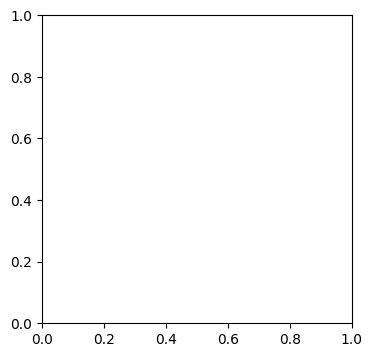

In [79]:
import matplotlib.pylab as plt

env.test = True

obs = env.reset()
demands=[]
Consumps=[]
rewards=[]
rew=[]
for i in range(24):
    action, _states = model.predict(obs, deterministic=True)
    obs, reward, dones, info = env.step(action)

    demand_range = df['Electricity:Facility [kW](Hourly)'][env.test_idx:env.test_idx + 24].reset_index(drop=True)
    demands.append(env.demand_pred)
    Consumps.append(env.consump)
    rewards.append(reward)
    rew.append(np.mean(rewards))
    if i==23:
        plt.figure(figsize =(4, 4))
        plt.plot(demands)
        plt.plot(Consumps)
        plt.legend(["determined demand","historical consumption"])

        plt.show()

plt.figure(figsize =(4, 4))
plt.plot(rewards)
plt.figure(figsize =(4, 4))
plt.plot(rew)

print(env.reward)
print(demands)